## Overview
The experiments are based on the works (Ahuja et.al. https://arxiv.org/pdf/2002.04692.pdf) and (Arjosvsky et.al. https://arxiv.org/pdf/1907.02893.pdf). 


1. In the first half of the notebook, we examine F-IRM game and V-IRM game (from Ahuja et.al.) for various different settings, e.g., different datasets, different number of environments, using different architectures MLP and CNN
2. In the latter half of the notebook, we examine IRM (Arjovsky et.al.) and standard empirical risk minimization (ERM). 



# Import external libraries

In [ ]:
import tensorflow as tf
import numpy as np
import argparse
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import pandas as pd
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
# import cProfile
import copy as cp
from sklearn.model_selection import KFold


# Data_constructor 
The datasets used in this project essentially modified standard datasets such as MNIST digits, fashion MNIST to create multiple environments with different degrees of spurious correlations and the labels. Here we describe the classes that allow to create these datasets.

    1. data_constructor consists of two classes: assemble_data_mnist() and assemble_data_mnist_fashion() 
        a) assemble_data_mnist()/assemble_data_mnist_fashion() has following functions 
            i) create_training_data(n_e, p_color_list, p_label_list):
                n_e: number of environments, 
                p_color_list: list of probabilities of switching the final label to obtain the color index, 
                p_label_list: list of probabilities of switching pre-label
            ii) create_testing_data(p_color_test, p_label_test, n_e): 
                n_e: number of environments, 
                p_color_test: probability of switching the final label to obtain the color index in test environment, 
                p_label_test: probability of switching pre-label in test environment
        b)  assemble_data_mnist()/assemble_data_mnist_fashion() following attributes:
            i) data_tuple_list: list of length n_e, each element of the list is a tuple with three elements (data, label, environment index)
            ii) data_tuple_test: tuple with three elements (data_test, label_test, test environment index)
    

MINST Fashion

In [ ]:
class assemble_data_mnist_fashion:
    def __init__(self):

        fashion_mnist = keras.datasets.fashion_mnist ## Load fashion MNIST data
        (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

        ## Prepare the data with labels (footwear or a clothing item, drop label 8 as it is a bag)
        sub_labels_train = np.where(train_labels!=8)
        train_images_new = train_images[sub_labels_train]
        train_labels_new = train_labels[sub_labels_train]

        sub_labels_test = np.where(test_labels!=8)
        test_images_new = test_images[sub_labels_test]
        test_labels_new = test_labels[sub_labels_test]


        train_labels_binary  = np.zeros_like(train_labels_new)
        test_labels_binary  = np.zeros_like(test_labels_new)
        train_labels_binary[np.where(train_labels_new==5)] = 1
        train_labels_binary[np.where(train_labels_new==7)] = 1
        train_labels_binary[np.where(train_labels_new==9)] = 1
        test_labels_binary[np.where(test_labels_new==5)] = 1
        test_labels_binary[np.where(test_labels_new==7)] = 1
        test_labels_binary[np.where(test_labels_new==9)] = 1

        x_train_fashion_mnist = train_images_new
        x_test_fashion_mnist  = test_images_new
        y_train_fashion_mnist = train_labels_binary
        y_test_fashion_mnist  = test_labels_binary

        ## convert data into float b/w 0-1
        x_train_fashion_mnist=x_train_fashion_mnist.astype('float32')/float(255)
        x_test_fashion_mnist=x_test_fashion_mnist.astype('float32')/float(255)

        num_train = x_train_fashion_mnist.shape[0]
        x_train_fashion_mnist = x_train_fashion_mnist.reshape((num_train,28,28,1))
        y_train_fashion_mnist = y_train_fashion_mnist.reshape((num_train,1))
                
        num_test = x_test_fashion_mnist.shape[0]
        x_test_fashion_mnist = x_test_fashion_mnist.reshape((num_test,28,28,1))
        y_test_fashion_mnist = y_test_fashion_mnist.reshape((num_test,1))
        
        self.x_train_fashion_mnist = x_train_fashion_mnist
        self.y_train_fashion_mnist = y_train_fashion_mnist

        self.x_test_fashion_mnist = x_test_fashion_mnist
        self.y_test_fashion_mnist = y_test_fashion_mnist 
        
    def create_environment(self,env_index,x,y,prob_e,prob_label):
        y = y.astype(int)
        num_samples=len(y)   
        y_mod=np.abs(y-np.random.binomial(1,prob_label,(num_samples,1)))
        z=np.abs(y_mod-np.random.binomial(1,prob_e,(num_samples,1)))
        red = np.where(z==1)[0]
        tsh = 0.5
        chR = cp.deepcopy(x[red,:])
        chR[chR > tsh] = 1
        chG = cp.deepcopy(x[red,:])
        chG[chG > tsh] = 0
        chB = cp.deepcopy(x[red,:])
        chB[chB > tsh] = 0
        r = np.concatenate((chR, chG), axis=3)
        green= np.where(z==0)[0]
        tsh= 0.5
        chR1= cp.deepcopy(x[green,:])
        chR1[chR1 > tsh] = 0
        chG1= cp.deepcopy(x[green,:])
        chG1[chG1 > tsh] = 1
        chB1= cp.deepcopy(x[green,:])
        chB1[chB1 > tsh] = 0
        g= np.concatenate((chR1, chG1), axis=3)
        dataset=np.concatenate((r,g),axis=0)
        labels=np.concatenate((y_mod[red,:],y_mod[green,:]),axis=0)
        return (dataset,labels,np.ones((num_samples,1))*env_index)
    
    def create_training_data(self, n_e, corr_list, p_label_list):
        x_train_fashion_mnist = self.x_train_fashion_mnist
        y_train_fashion_mnist = self.y_train_fashion_mnist
        ind_X = range(0,54000)
        kf = KFold(n_splits=n_e, shuffle=True)
        l=0
        ind_list =[]
        for train, test in kf.split(ind_X):
            ind_list.append(test)
            l=l+1   
        data_tuple_list = []
        for l in range(n_e):
            data_tuple_list.append(self.create_environment(l,x_train_fashion_mnist[ind_list[l],:,:,:],y_train_fashion_mnist[ind_list[l],:],corr_list[l],p_label_list[l]))
            
        self.data_tuple_list = data_tuple_list
        
    
    def create_testing_data(self, corr_test, prob_label, n_e):
        x_test_fashion_mnist = self.x_test_fashion_mnist
        y_test_fashion_mnist = self.y_test_fashion_mnist        
        (x_test,y_test,e_test)=self.create_environment(n_e,x_test_fashion_mnist,y_test_fashion_mnist,corr_test,prob_label)

        self.data_tuple_test = (x_test,y_test, e_test)

        
        




MINST

In [ ]:
class assemble_data_mnist:
    def __init__(self):
        D=tf.keras.datasets.mnist.load_data()
        x_train=D[0][0].astype(float)
        #y_train=OneHotEncoder.fit_transform(y_train)
        x_test=D[1][0].astype(float)
        #y_test=OneHotEncoder.fit_transform(y_train)
        num_train=x_train.shape[0]
        self.x_train_mnist=x_train.reshape((num_train,28,28,1))
        self.y_train_mnist=D[0][1].reshape((num_train,1))
        num_test=x_test.shape[0]
        self.x_test_mnist=x_test.reshape((num_test,28,28,1))
        self.y_test_mnist=D[1][1].reshape((num_test,1))

    def create_environment(self,env_index,x,y,prob_e,prob_label):
        #Convert y>5 to 1 and y<5 to 0.
        y= (y>=5).astype(int)
        num_samples=len(y)
        y_mod=np.abs(y-np.random.binomial(1,prob_label,(num_samples,1)))
        z=np.abs(y_mod-np.random.binomial(1,prob_e,(num_samples,1)))

        red = np.where(z==1)[0]
        tsh = 0.5
        chR = cp.deepcopy(x[red,:])
        chR[chR > tsh] = 1
        chG = cp.deepcopy(x[red,:])
        chG[chG > tsh] = 0
        chB = cp.deepcopy(x[red,:])
        chB[chB > tsh] = 0
        r = np.concatenate((chR, chG), axis=3)

        green= np.where(z==0)[0]
        tsh= 0.5
        chR1= cp.deepcopy(x[green,:])
        chR1[chR1 > tsh] = 0
        chG1= cp.deepcopy(x[green,:])
        chG1[chG1 > tsh] = 1
        chB1= cp.deepcopy(x[green,:])
        chB1[chB1 > tsh] = 0
        g= np.concatenate((chR1, chG1), axis=3)

        dataset=np.concatenate((r,g),axis=0)
        labels=np.concatenate((y_mod[red,:],y_mod[green,:]),axis=0)

        return (dataset,labels,np.ones((num_samples,1))*env_index)
    
    def create_training_data(self, n_e, corr_list, p_label_list):
            x_train_mnist = self.x_train_mnist
            y_train_mnist = self.y_train_mnist
            ind_X = range(0,60000)
            kf = KFold(n_splits=n_e, shuffle=True)
            l=0
            ind_list =[]
            for train, test in kf.split(ind_X):
                ind_list.append(test)
                l=l+1   
            data_tuple_list = []
            for l in range(n_e):
                data_tuple_list.append(self.create_environment(l,x_train_mnist[ind_list[l],:,:,:],y_train_mnist[ind_list[l],:],corr_list[l],p_label_list[l]))

            self.data_tuple_list = data_tuple_list
            
    def create_testing_data(self, corr_test, prob_label, n_e):
        x_test_mnist = self.x_test_mnist
        y_test_mnist = self.y_test_mnist        
        (x_test,y_test,e_test)=self.create_environment(n_e,x_test_mnist,y_test_mnist,corr_test
,prob_label)

        self.data_tuple_test = (x_test,y_test, e_test)

# IRM_methods

##    1. Fixed_irm_game_model class. Implements fixed-IRM game from Ahuja et.al.
    
        A) Initialization:
        fixed_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start)
           i) model_list: list of models for each environment; use keras to construct the architectures
           ii) learning_rate: learning rate for Adam optimizer for training the models for each environment
           iii) batch_size: size of the batch used for each gradient update
            iv) num_epochs: number of epochs is number of training steps = number of training samples//batch size (each epoch is one full pass of the training data)
            v) termination_acc: once the model accuracy falls below this threshold we terminate training
           vi) warm_start: minimum number of steps before we terminate due to accuracy falling below threshold

        B) Methods:
            i) fit(data_tuple_list): takes data_tuple_list and trains the models
                   data_tuple_list- list of length n_e, each element of the list is a tuple with three elements (data, label, environment index)     
            ii) evaluate(data_tuple_test): tuple with three elements (data_test, label_test, test environment index)

        C) Attributes:
            i) model_list: list of models for each environment
            ii) train_acc: training accuracy (use after running evaluate method)
            iii) test_acc: testing accuracy  (use after running evaluate method) 

     



In [ ]:
class fixed_irm_game_model:
    def __init__(self, model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start):
        
        self.model_list        = model_list             # list of models for all the environments
        self.num_epochs        = num_epochs             # number of epochs 
        self.batch_size        = batch_size             # batch size for each gradient update
        self.termination_acc   = termination_acc        # threshold on accuracy below which we terminating 
        self.warm_start        = warm_start             # minimum number of steps we have to train before terminating due to accuracy falling below threshold
        self.learning_rate     = learning_rate          # learning rate in adam
    
    def fit(self, data_tuple_list):
        n_e  = len(data_tuple_list)                     # number of environments
        # combine the data from the different environments x_in: combined data from environments, y_in: combined labels from environments, e_in: combined environment indices from environments
        x_in = data_tuple_list[0][0]
        for i in range(1,n_e):
            x_c = data_tuple_list[i][0]
            x_in = np.concatenate((x_in, x_c), axis=0)
        y_in = data_tuple_list[0][1]
        for i in range(1,n_e):
            y_c = data_tuple_list[i][1]
            y_in = np.concatenate((y_in, y_c), axis=0)
        e_in = data_tuple_list[0][2]
        for i in range(1,n_e):
            e_c = data_tuple_list[i][2]
            e_in = np.concatenate((e_in, e_c), axis=0) 
            
        # cross entropy loss
        def loss_comb(model_list, x, y):
            loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            n_e = len(model_list)
            y_ = tf.zeros_like(y, dtype=tf.float32)
            # predict the model output from the ensemble
            for i in range(n_e):
                model_i = model_list[i]
                y_ = y_ + 0.5*model_i(x)

            return loss_object(y_true=y, y_pred=y_)
        # gradient of cross entropy loss for environment e
        def grad_comb(model_list, inputs, targets, e):
            with tf.GradientTape() as tape:
                loss_value = loss_comb(model_list, inputs, targets)
            return loss_value, tape.gradient(loss_value, model_list[e].trainable_variables)



    
        model_list = self.model_list
        learning_rate = self.learning_rate


        # initialize optimizer for all the environments and representation learner and store it in a list
        optimizer_list = []
        for e in range(n_e):
            optimizer_list.append(tf.keras.optimizers.Adam(learning_rate=learning_rate))

        ####### train

        train_accuracy_results_0 = []   # list to store training accuracy


        flag = 'false'
        num_epochs = self.num_epochs
        batch_size = self.batch_size
        num_examples= data_tuple_list[0][0].shape[0]
        period      = n_e               
        termination_acc = self.termination_acc
        warm_start      = self.warm_start
        steps           = 0
        for epoch in range(num_epochs):
            print ("Epoch: "  + str(epoch))
            datat_list = []
            for e in range(n_e):
                x_e = data_tuple_list[e][0]
                y_e = data_tuple_list[e][1]
                datat_list.append(shuffle(x_e,y_e)) 
            count = 0
            for offset in range(0,num_examples, batch_size):
                end = offset + batch_size
                batch_x_list = []  # list to store batches for each environment
                batch_y_list = []  # list to store batches of labels for each environment
                loss_value_list = []  # list to store loss values
                grads_list      = []  # list to store gradients
                countp = count % period # countp decides the index of the model which trains in the current step
                for e in range(n_e):
                    batch_x_list.append(datat_list[e][0][offset:end,:])
                    batch_y_list.append(datat_list[e][1][offset:end,:])
                    loss_value, grads = grad_comb(model_list, batch_x_list[e], batch_y_list[e],e)
                    grads_list.append(grads)
                # update the environment whose turn it is to learn
                optimizer_list[countp].apply_gradients(zip(grads_list[countp], model_list[countp].trainable_variables))

                # computing training accuracy
                y_ = tf.zeros_like(y_in, dtype=tf.float32)
                for e in range(n_e):
                    y_ = y_ + model_list[e](x_in)
                epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
                acc_train = np.float(epoch_accuracy(y_in, y_))
                train_accuracy_results_0.append(acc_train)
                
                if(steps>=warm_start and acc_train<termination_acc): ## Terminate after warm start and train acc touches threshold we dont want it to fall below 
                    flag = 'true' 
                    break      

                count = count +1
                steps = steps +1
                self.train_accuracy_results = train_accuracy_results_0
            if (flag == 'true'):
                break
        self.model_list = model_list 
        
        self.x_in      = x_in
        self.y_in      = y_in

       
    def evaluate(self, data_tuple_test):
        ##### evaluations jmtd
        x_test = data_tuple_test[0]
        y_test = data_tuple_test[1]
        x_in   = self.x_in
        y_in   = self.y_in
        
        model_list = self.model_list
        n_e        = len(model_list)
        train_accuracy= tf.keras.metrics.SparseCategoricalAccuracy()
        test_accuracy= tf.keras.metrics.SparseCategoricalAccuracy()

        ytr_ = tf.zeros_like(y_in, dtype=tf.float32)
        for e in range(n_e):
            ytr_ = ytr_ + model_list[e](x_in)
        train_acc =  np.float(train_accuracy(y_in, ytr_))

        yts_ = tf.zeros_like(y_test, dtype=tf.float32)
        for e in range(n_e):
            yts_ = yts_ + model_list[e](x_test) 

        test_acc  =  np.float(test_accuracy(y_test, yts_))
        
        self.train_acc = train_acc
        self.test_acc  = test_acc

## 2. Variable_irm_game_model class. Implements variable-IRM game from Ahuja et.al.. It has same hyperparameters, methods and attributes as  fixed_irm_game_model. 
    
        A) Initialization: variable_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start)
           i) model_list: list of models for each environment and the representation learner; note the main difference between variable_irm_game_model and fixed_irm_game_model is model_list also contains a model for the representation learner that we learn 
           ii) learning_rate: learning rate for Adam optimizer for training the models for each environment
           iii) batch_size: size of the batch used for each gradient update
            iv) num_epochs: number of epochs is number of training steps = number of training samples//batch size (each epoch is one full pass of the training data)
           v) termination_acc: once the model accuracy falls below this threshold we terminate training
            vi) warm_start: minimum number of steps before we terminate due to accuracy falling below threshold

        B) Methods:
            i) fit(data_tuple_list): takes data_tuple_list and trains the models
                   data_tuple_list: list of length n_e, each element of the list is a tuple with three elements (data, label, environment index)

            ii) evaluate(data_tuple_test): tuple with three elements (data_test, label_test, test environment index)

        C) Attributes:
            i) model_list: list of models for each environment
            ii) train_acc: training accuracy (use after running evaluate method)
            iii) test_acc: testing accuracy  (use after running evaluate method) 

    

In [ ]:
class variable_irm_game_model:
    def __init__(self, model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start):
        
        self.model_list        = model_list          # list of models for the environments and representation learner
        self.num_epochs        = num_epochs          # number of epochs
        self.batch_size        = batch_size          # batch size for each gradient update
        self.termination_acc   = termination_acc     # threshold on accuracy below which we terminate
        self.warm_start        = warm_start          # minimum number of steps before terminating
        self.learning_rate     = learning_rate       # learning rate for Adam optimizer
    
    def fit(self, data_tuple_list):
        n_e  = len(data_tuple_list)                                # number of environments
        # combine the data from the different environments x_in: combined data (features) from environments, y_in: combined labels from environments, e_in: combined environment indices from environments
        x_in = data_tuple_list[0][0]              
        for i in range(1,n_e):
            x_c = data_tuple_list[i][0]
            x_in = np.concatenate((x_in, x_c), axis=0)
        y_in = data_tuple_list[0][1]
        for i in range(1,n_e):
            y_c = data_tuple_list[i][1]
            y_in = np.concatenate((y_in, y_c), axis=0)
        e_in = data_tuple_list[0][2]
        for i in range(1,n_e):
            e_c = data_tuple_list[i][2]
            e_in = np.concatenate((e_in, e_c), axis=0) 
            
        # cross entropy loss
        def loss_comb(model_list, x, y):
            loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            n_e = len(model_list)-1
            y_ = tf.zeros_like(y, dtype=tf.float32)
            # pass the data from the representation learner
            z = model_list[n_e](x) 
            # pass the output from the representation learner into the environments and aggregate them 
            for i in range(n_e):
                model_i = model_list[i]
                y_ = y_ + 0.5*model_i(z)


            return loss_object(y_true=y, y_pred=y_)

        # gradient of cross entropy loss for environment e
        def grad_comb(model_list, inputs, targets, e):
            with tf.GradientTape() as tape:
                loss_value = loss_comb(model_list, inputs, targets)
            return loss_value, tape.gradient(loss_value, model_list[e].trainable_variables)


        model_list = self.model_list
        learning_rate = self.learning_rate
        
        # initialize optimizer for all the environments and representation learner and store it in a list
        optimizer_list = []
        for e in range(n_e+1):
            if (e<=n_e-1):
                optimizer_list.append(tf.keras.optimizers.Adam(learning_rate=learning_rate))
            if (e==n_e):
                optimizer_list.append(tf.keras.optimizers.Adam(learning_rate=learning_rate*0.1))


        ####### train

        train_accuracy_results_0 = []   # list to store training accuracy  


        flag = 'false'
        num_epochs = self.num_epochs
        batch_size = self.batch_size
        num_examples= data_tuple_list[0][0].shape[0]
        period      = n_e+1               # 
        termination_acc = self.termination_acc
        warm_start      = self.warm_start
        steps           = 0
        for epoch in range(num_epochs):
            print ("Epoch: " + str(epoch))
            datat_list = []
            for e in range(n_e+1):
                if(e<=n_e-1):
                    x_e = data_tuple_list[e][0]
                    y_e = data_tuple_list[e][1]
                    datat_list.append(shuffle(x_e,y_e)) 
                if (e==n_e):
                    datat_list.append(shuffle(x_in,y_in)) 
            count = 0
            for offset in range(0,num_examples, batch_size):
                end = offset + batch_size
                batch_x_list = [] # list to store batches for each environment
                batch_y_list = [] # list to store batches of labels for each environment
                loss_value_list = [] # list to store loss values
                grads_list      = [] # list to store gradients
                countp = period- 1- (count % period)  # countp decides the index of the model which trains in the current step
                for e in range(n_e+1):
                    batch_x_list.append(datat_list[e][0][offset:end,:])
                    batch_y_list.append(datat_list[e][1][offset:end,:])
                    loss_value, grads = grad_comb(model_list, batch_x_list[e], batch_y_list[e],e)
                    grads_list.append(grads)

                # update either a representation learner or an environment model  
                optimizer_list[countp].apply_gradients(zip(grads_list[countp], model_list[countp].trainable_variables))

                # computing training accuracy
                y_ = tf.zeros_like(y_in, dtype=tf.float32)
                z_in = model_list[n_e](x_in)
                for e in range(n_e):
                    y_ = y_ + model_list[e](z_in)
                epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
                acc_train = np.float(epoch_accuracy(y_in, y_))
                train_accuracy_results_0.append(acc_train)
                
                if(steps>=warm_start and acc_train<termination_acc): # Terminate after warm start and train accuracy touches threshold we dont want it to fall below 
                    flag = 'true' 
                    break      
                count = count +1
                steps = steps +1
                self.train_accuracy_results = train_accuracy_results_0
            if (flag == 'true'):
                break
                
        self.model_list = model_list 
        
        self.x_in      = x_in
        self.y_in      = y_in

        
        
        
    def evaluate(self, data_tuple_test):
        ##### evaluations jmtd
        x_test = data_tuple_test[0]
        y_test = data_tuple_test[1]
        x_in   = self.x_in
        y_in   = self.y_in
        
        model_list = self.model_list
        n_e        = len(model_list)-1
        train_accuracy= tf.keras.metrics.SparseCategoricalAccuracy()
        test_accuracy= tf.keras.metrics.SparseCategoricalAccuracy()
        

        # compute training accuracy
        ytr_ = tf.zeros_like(y_in, dtype=tf.float32)
        z_in = model_list[n_e](x_in)
        for e in range(n_e):
            ytr_ = ytr_ + model_list[e](z_in)
        train_acc =  np.float(train_accuracy(y_in, ytr_))

        # compute testing accuracy
        z_test = model_list[n_e](x_test)
        yts_ = tf.zeros_like(y_test, dtype=tf.float32)
        for e in range(n_e):
            yts_ = yts_ + model_list[e](z_test) 

        test_acc  =  np.float(test_accuracy(y_test, yts_))
        
        self.train_acc = train_acc
        self.test_acc  = test_acc

##3. Irm_model. Implements IRM v1 from Arjovsky et.al. 

        A) Initialization:
            irm_model(model_irm, learning_rate, batch_size, steps_max, steps_threshold, gamma_new)
            i) model_irm: a keras model passed as input
            ii) learning_rate: learning rate for Adam optimizer
            iii) batch_size: size of the batch per gradient update
            iv) steps_max: maximum number of gradient updates
            v) steps_threshold: threshold after which to update the penalty value
            vi) gamma_new: penatly to be used after steps_threshold, upto steps_threshold a penalty of gamma=1 is used

        B) Methods:
            i) fit(data_tuple_list): takes data_tuple_list and trains the model
                   data_tuple_list- list of length n_e, each element of the list is a tuple with three elements (data, label, environment index)     
            ii) evaluate(data_tuple_test): tuple with three elements (data_test, label_test, test environment index) 

         C) Attributes:
                i) train_acc: training accuracy (use after running evaluate method)
                ii) test_acc: testing accuracy  (use after running evaluate method) 

      

In [ ]:
class irm_model:
    def __init__(self, model, learning_rate, batch_size, steps_max, steps_threshold, gamma_new):
        self.model= model                                 # initialized model passed
        self.learning_rate = learning_rate                # learning rate for Adam optimizer
        self.batch_size    = batch_size                   # batch size per gradient update
        self.steps_max     = steps_max                    # maximum number of gradient steps
        self.steps_threshold = steps_threshold            # threshold on the number of steps after which we use penalty gamma_new
        self.gamma_new      = gamma_new                   # penalty value; note penalty is set to 1 initially and gamma_new only kicks in after steps exceeed steps_threshold
    
    def fit(self,data_tuple_list):
        
        n_e  = len(data_tuple_list)                       # number of environments
        # combine the data from the different environments, x_in: combined data (features) from different environments
        x_in = data_tuple_list[0][0]
        for i in range(1,n_e):
            x_c = data_tuple_list[i][0]
            x_in = np.concatenate((x_in, x_c), axis=0)
        y_in = data_tuple_list[0][1]
        for i in range(1,n_e):
            y_c = data_tuple_list[i][1]
            y_in = np.concatenate((y_in, y_c), axis=0)
        e_in = data_tuple_list[0][2]
        for i in range(1,n_e):
            e_c = data_tuple_list[i][2]
            e_in = np.concatenate((e_in, e_c), axis=0) 
        
        self.x_in = x_in
        self.y_in = y_in
        
        # cross entropy (we do not use the cross entropy from keras because there are issues when computing gradient of the gradient)
        def cross_entropy_manual(y,y_pred):
            y_p = tf.math.log(tf.nn.softmax(y_pred))
            n_p = np.float(tf.shape(y_p)[0])
            ind_0 = tf.where(y==0)[:,0]
            ind_1 = tf.where(y==1)[:,0]
            y_p0  = tf.gather(y_p, ind_0)[:,0]
            y_p1  = tf.gather(y_p, ind_1)[:,1]
            ent_0 = tf.reduce_sum(y_p0)
            ent_1 = tf.reduce_sum(y_p1)
            total = -(ent_0 + ent_1)/n_p
            return total

        # cross entropy loss for environment e
        def loss_n(model,x,e,y,w,k):
            index = np.where(e==k)
            y1_ = model(x[index[0]])*w
            y1  = y[index[0]]

            return cross_entropy_manual(y1,y1_)   

        # gradient of cross entropy loss w.r.t w for environment e
        def grad_norm_n(model,x,e,y,w,k):
            with tf.GradientTape() as g:
                g.watch(w)
                loss_value = loss_n(model,x,e,y,w,k)  
            return g.gradient(loss_value, w)**2

        # total cross entropy loss across all environments    
        def loss_0(model, x,e,y,w):
            y_ =model(x)
            loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            return loss_object(y_true=y, y_pred=y_)
        
        # sum of cross entropy loss and penalty 
        def loss_total(model,x,e,y,w,gamma, n_e):
            loss0 = loss_0(model,x,e,y,w)
            loss_penalty = 0.0
            for k in range(n_e):
                loss_penalty += gamma*grad_norm_n(model,x,e,y,w,k)

            return (loss0 + loss_penalty)*(1/gamma)        
        
        # gradient of sum of cross entropy loss and penalty w.r.t model parameters
        def grad_total_n(model,x,e,y,w,gamma, n_e):
            with tf.GradientTape() as tape:
                loss_value = loss_total(model,x,e,y,w,gamma,n_e)
            return loss_value, tape.gradient(loss_value, model.trainable_variables)
        
        model = self.model
        learning_rate = self.learning_rate
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        ## train 
        train_loss_results = []
        train_accuracy_results = []
        flag = 'false'
        batch_size = self.batch_size
        num_examples= x_in.shape[0]
        gamma     = 1.0
        w         = tf.constant(1.0)
        steps     = 0
        steps_max  = self.steps_max
        steps_threshold = self.steps_threshold
        gamma_new       = self.gamma_new
        while(steps<=steps_max):
            (xt,yt,et)   = shuffle(x_in,y_in,e_in)
            epoch_loss_avg = tf.keras.metrics.Mean()
            epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
            count = 0
            if(steps>=steps_threshold):
                gamma = gamma_new
            for offset in range(0,num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y, batch_e = xt[offset:end,:], yt[offset:end,:], et[offset:end,:]
                loss_values, grads = grad_total_n(model,batch_x,batch_e,batch_y,w,gamma,n_e)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                epoch_loss_avg(loss_values)    
                epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
                acc_train = np.float(epoch_accuracy(y_in, model(x_in)))
                train_loss_results.append(epoch_loss_avg.result())
                train_accuracy_results.append(epoch_accuracy.result())
                count = count +1 
                steps = steps + 1
            
    def evaluate(self, data_tuple_test):
        x_test = data_tuple_test[0]
        y_test = data_tuple_test[1]
        x_in   = self.x_in
        y_in   = self.y_in
        train_accuracy= tf.keras.metrics.SparseCategoricalAccuracy()
        test_accuracy= tf.keras.metrics.SparseCategoricalAccuracy()
        model  = self.model
        ytr_ = model.predict(x_in)
        train_acc =  np.float(train_accuracy(y_in, ytr_))
        
        yts_ = model.predict(x_test)
        test_acc =  np.float(test_accuracy(y_test, yts_))
        
        self.train_acc = train_acc
        self.test_acc  = test_acc



##4. Standard_erm_model. Implements standard empirical risk minimization. 
        A) Initialization: 
            standard_erm_model(model_erm, num_epochs, batch_size):
                i) model_erm: a keras model passed as input
                ii) num_epochs: number of epochs
                iii) batch_size: size of batch per gradient update
                iv) learning_rate: learning rate for Adam optimizer
        
        B) Methods:
            i) fit(data_tuple_list): takes data_tuple_list and trains the model
                   data_tuple_list- list of length n_e, each element of the list is a tuple with three elements (data, label, environment index)     
            ii) evaluate(data_tuple_test): tuple with three elements (data_test, label_test, test environment index) 


         C) Attributes:
                i) train_acc: training accuracy (use after running evaluate method)
                ii) test_acc: testing accuracy  (use after running evaluate method)    
     

In [ ]:
class standard_erm_model:
    def __init__(self, model,  num_epochs, batch_size, learning_rate):
        
        self.model        = model
        self.num_epochs   = num_epochs
        self.batch_size   = batch_size
        self.learning_rate=learning_rate
    
    def fit(self, data_tuple_list):
        learning_rate = self.learning_rate
        num_epochs = self.num_epochs
        n_e  = len(data_tuple_list)
        x_in = data_tuple_list[0][0]
        for i in range(1,n_e):
            x_c = data_tuple_list[i][0]
            x_in = np.concatenate((x_in, x_c), axis=0)
        y_in = data_tuple_list[0][1]
        for i in range(1,n_e):
            y_c = data_tuple_list[i][1]
            y_in = np.concatenate((y_in, y_c), axis=0)
        e_in = data_tuple_list[0][2]
        for i in range(1,n_e):
            e_c = data_tuple_list[i][2]
            e_in = np.concatenate((e_in, e_c), axis=0) 
        

    ### fit the model
        model = self.model
        batch_size = self.batch_size


        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

        model.fit(x_in, y_in,  epochs=num_epochs, batch_size=batch_size)
  
        self.x_in      = x_in
        self.y_in      = y_in      
        


        
        
        
    def evaluate(self, data_tuple_test):
        ##### evaluations jmtd
        x_test = data_tuple_test[0]
        y_test = data_tuple_test[1]
        x_in   = self.x_in
        y_in   = self.y_in
        
        model = self.model
        train_accuracy= tf.keras.metrics.SparseCategoricalAccuracy()
        test_accuracy= tf.keras.metrics.SparseCategoricalAccuracy()

        ytr_ = model.predict(x_in)
        train_acc =  np.float(train_accuracy(y_in, ytr_))

        yts_ = model.predict(x_test)

        test_acc  =  np.float(test_accuracy(y_test, yts_))
        
        self.train_acc = train_acc
        self.test_acc  = test_acc

# IRM 

#### Training data:
Data from different environments $\mathcal{D} = \{\{(x_i^{q},y_i^{q}\}_{i=1}^{n_q}\}_{q=1}^{K}$, where $K$ is number of environments and $n_q$ is number of points in environment with index $q$.

#### Invariant predictor:  
Define a representation $\phi:\mathcal{X} \rightarrow \mathcal{Z}$ and a classifier $w: \mathcal{Z} \rightarrow \mathbb{R}^k$. The predictor is composite function $w\circ \phi$. We define a predictor $w\circ \phi$ to be invariant if a same classifier $w$ minimizes the risk across all the environments, i.e. $w \in \arg\min_{\bar{w}} R^{e}(\bar{w}\circ \phi), \forall e \in \{1,.., K\} $, where risk is expected loss of predictor w.r.t labels.

#### IRM from Arjovsky et.al. objective 

Consider the following alternate minimization problem 

$\min_{\phi} \sum_{q=1}^{K}R^{q}(\phi)  + \lambda \sum_{q=1}^{K}\nabla_{w |w=1.0} R^{q}(w.\Phi)$

We use the above objective to train a neural network that model for $\phi$ 


#### IRM games Ahuja et.al. objective 

Define a classifier for each environment $w^q: \mathcal{X} \rightarrow \mathbb{R}^k$ and $w^{av}= \frac{1}{K}\sum_{q=1}^{K}w^{q}$.  

The objective of each environment $e$ is $R^{e}(w^{av} \circ \phi) $, where $w^{av}= \frac{1}{K}\sum_{q=1}^{K}w^{q}$. 

In the F-IRM approach (F-IRM game). We fix $\phi$ to identity. Each environment takes turn to optimize $R^{e}(w^{av} \circ \phi) $. The environment $e$ updates the classifier  $w^e$ using SGD  step $R^{e}(w^{av} \circ \phi) $.

In the V-IRM approach (V-IRM game).  The objective of the representation learner  is $\sum_{q=1}^{K}R^{q}(w^{av} \circ \phi) $. The representation learner updates $\phi$ using SGD updates and between two updates environments takes turn to update $w^e$.
Each environment takes turn to optimize $R^{e}(w^{av} \circ \phi) $. The environment $e$ updates the classifier  $w^e$ using SGD  step $R^{e}(w^{av} \circ \phi) $.  







# MNIST digits:  2 environments

Below we illustrate how to use our IRM methods. 
We first setup the data in the cell below.  We set p_color_list = [0.2, 0.1] (from experiments in Arjovsky et.al.); note that there is marginal difference between the probabilities of switching the labels in the two environments. This marginal difference is useful for IRM methods to learn invariant predictors across environments that exploit the shape of digits and not the color. 

In [ ]:
# Create data for each environment

n_e = 2  # number of environments

p_color_list = [0.2, 0.1] # list of probabilities of switching the final label to obtain the color index
p_label_list = [0.25]*n_e # list of probabilities of switching pre-label
D = assemble_data_mnist() # initialize mnist digits data object

D.create_training_data(n_e, p_color_list, p_label_list) # creates the training environments

p_label_test = 0.25 # probability of switching pre-label in test environment
p_color_test = 0.9  # probability of switching the final label to obtain the color index in test environment

D.create_testing_data(p_color_test, p_label_test, n_e)  # sets up the testing environment
(num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

11501568/11490434 [==============================] - 0s 0us/step


### Initialize the architecture for F-IRM game 

In the cell below, for each environment we initialize an architecture. We use the MLP architectue that was described in https://arxiv.org/pdf/2002.04692.pdf . 

If you decide to choose a new architecture, please take care to ensure that you keep the input shape as is that is length, width, and height (which we obtained above) and output shape as num_classes.

In [ ]:
# we use same architecture across environments and store it in a list
model_list = [] 
for e in range(n_e):
    model_list.append(keras.Sequential([
            keras.layers.Flatten(input_shape=(length, width,height)),
            keras.layers.Dense(390, activation = 'elu'),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(390, activation='elu'),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(num_classes)
    ]))

### Select other hyper-parameters for the F-IRM game


In [ ]:

num_epochs       = 25
batch_size       = 256
termination_acc  = 0.6
warm_start       = 100
learning_rate    = 2.5e-4

# other hyper-parameters to try 
# num_epochs       = 25
# batch_size       = 256
# termination_acc  = 0.53
# warm_start       = 100
# learning_rate    = 5e-4

### Initialize F-IRM model, fit and evaluate

In [ ]:
# initialize F-IRM model (we pass the hyper-parameters that we chose above)
F_game = fixed_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start) 

# fit function runs the training on the data that we created
F_game.fit(D.data_tuple_list)

# evaluate function runs and evaluates train and test accuracy of the final model
F_game.evaluate(D.data_tuple_test) 

# print train and test accuracy
print ("Training accuracy " + str(F_game.train_acc)) 
print ("Testing accuracy " + str(F_game.test_acc))

Epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Training accuracy 0.5971666574478149
Testing accuracy 0.6068999767303467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Selecting termination_acc using training accuracy plot

1. Start by setting a very low termination accuracy value say 0.1 and large number of epochs. 
2. Plot the training accuracy plot to see the range of oscillations; use the minimum value around which oscillation occurs as the threshold 

3. In the above experiment, we found 0.6 to be the value based on the plot. 

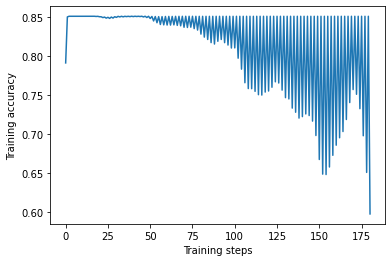

In [ ]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(F_game.train_accuracy_results)

### Initialize the architecture for V-IRM game 

In the cell below, for each environment we initialize an architecture. We use the MLP architectue that was described in https://arxiv.org/pdf/2002.04692.pdf.

If you choose a new architecture, please take care to ensure that you keep the input shape as length, width, and height (which we obtained above) and output shape is num_classes.

In [ ]:

model_list = [] # we use same architecture across environments and store it in a list and the last element of the list 
# corresponds to the architecture for the representation learner
for e in range(n_e+1):
    if(e<=n_e-1): 
        model_list.append( keras.Sequential([
            keras.layers.Flatten(input_shape=(390,1)),
            keras.layers.Dense(390, activation = 'elu'),
            keras.layers.Dropout(0.75),
            keras.layers.Dense(390, activation='elu'),
            keras.layers.Dropout(0.75),
            keras.layers.Dense(num_classes)
        ]))
    if(e==n_e):
        model_list.append(keras.Sequential([
        keras.layers.Flatten(input_shape=(length, width,height)),
        keras.layers.Dense(390, activation = 'elu',kernel_regularizer=keras.regularizers.l2(0.00125)),
      ]))

### Select other hyper-parameters for the V-IRM game


In [ ]:

num_epochs       = 25
batch_size       = 256
termination_acc  = 0.55
warm_start       = 100
learning_rate    = 2.5e-4


### Initialize V-IRM model, fit and evaluate

In [ ]:
# initialize V-IRM model (we pass the hyper-parameters that we chose above)
V_game = variable_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start) 

# fit function runs the training on the data that we created
V_game.fit(D.data_tuple_list) 

# evaluate function runs and evaluates train and test accuracy of the final model
V_game.evaluate(D.data_tuple_test) 

# print train and test accuracy
print (V_game.train_acc)
print (V_game.test_acc)

Epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch: 1
Epoch: 2
Epoch: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.534850001335144
0.5981000065803528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Selecting termination_acc using training accuracy plot


1. Start by setting a very low termination accuracy value say 0.1 and large number of epochs. 
2. Plot the training accuracy plot to see the range of oscillations; use the minimum value around which oscillation occurs as the threshold 

3. In the above experiment, we found 0.55 to be the value based on the plot.  

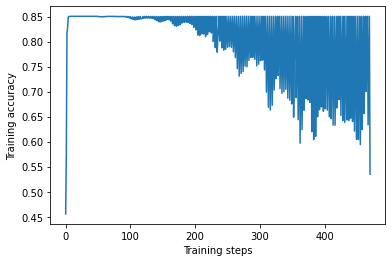

In [ ]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(V_game.train_accuracy_results)

# Fashion MNIST: 2 environments

We replicate the same experiments as above for Fashion MNIST data. 

In [ ]:
# Create data for each environment

n_e = 2    # number of environments

p_color_list = [0.2, 0.1]   # list of probabilities of switching the final label to obtain the color index
p_label_list = [0.25]*n_e   # list of probabilities of switching pre-label
D = assemble_data_mnist_fashion()  # initialize mnist fashion data object

D.create_training_data(n_e, p_color_list, p_label_list) # create the training environments
p_label_test = 0.25     # probability of switching pre-label in test environment
p_color_test = 0.9      # probability of switching the final label to obtain the color index in test environment

D.create_testing_data(p_color_test, p_label_test, n_e)  # create the testing environments
(num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

4431872/4422102 [==============================] - 0s 0us/step


### Initialize the architecture for F-IRM game 

In [ ]:
# we use same architecture across environments and store it in a list
model_list = [] 
for e in range(n_e):
    model_list.append(keras.Sequential([
            keras.layers.Flatten(input_shape=(length, width,height)),
            keras.layers.Dense(390, activation = 'elu'),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(390, activation='elu'),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(num_classes)
    ]))

### Select other hyper-parameters for the F-IRM game

In [ ]:

num_epochs       = 25
batch_size       = 256
termination_acc  = 0.6
warm_start       = 100
learning_rate    = 2.5e-4


### Initialize F-IRM model, fit and evaluate

In [ ]:
# initialize F-IRM model (we pass the hyper-parameters that we chose above)
F_game = fixed_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start) 

# fit function runs the training on the data that we created
F_game.fit(D.data_tuple_list)

# evaluate function runs and evaluates train and test accuracy of the final model
F_game.evaluate(D.data_tuple_test) 

# print train and test accuracy
print ("Training accuracy " + str(F_game.train_acc)) 
print ("Testing accuracy " + str(F_game.test_acc))

Epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Training accuracy 0.5943518280982971
Testing accuracy 0.5208888649940491


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Selecting termination_acc using training accuracy plot

1. Start by setting a very low termination accuracy value say 0.1 and large number of epochs. 
2. Plot the training accuracy plot to see the range of oscillations; use the minimum value around which oscillation occurs as the threshold 

3. In the above experiment, we found 0.6 to be the value based on the plot. 

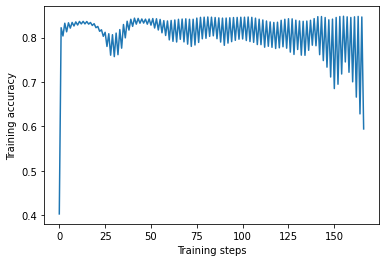

In [ ]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(F_game.train_accuracy_results)

### Initialize the architecture for V-IRM game

In [ ]:
model_list = [] # we use same architecture across environments and store it in a list and the last element of the list 
# corresponds to the architecture for the representation learner
for e in range(n_e+1):
    if(e<=n_e-1): 
        model_list.append( keras.Sequential([
            keras.layers.Flatten(input_shape=(390,1)),
            keras.layers.Dense(390, activation = 'elu',kernel_regularizer=keras.regularizers.l2(0.00125)),
            keras.layers.Dropout(0.75),
            keras.layers.Dense(390, activation='elu',kernel_regularizer=keras.regularizers.l2(0.00125)),
            keras.layers.Dropout(0.75),
            keras.layers.Dense(num_classes)
        ]))
    if(e==n_e):
        model_list.append(keras.Sequential([
        keras.layers.Flatten(input_shape=(length, width, height)),
        keras.layers.Dense(390, activation = 'elu',kernel_regularizer=keras.regularizers.l2(0.00125)),
      ]))

### Select other hyper-parameters for the V-IRM game


In [ ]:

num_epochs       = 25
batch_size       = 256
termination_acc  = 0.6
warm_start       = 100
learning_rate    = 2.5e-4


### Initialize V-IRM model, fit and evaluate

In [ ]:
# initialize V-IRM model (we pass the hyper-parameters that we chose above)
V_game = variable_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start) 

# fit function runs the training on the data that we created
V_game.fit(D.data_tuple_list) 

# evaluate function runs and evaluates train and test accuracy of the final model
V_game.evaluate(D.data_tuple_test) 

# print train and test accuracy
print (V_game.train_acc)
print (V_game.test_acc)

Epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.5920185446739197
0.3278888761997223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Selecting termination_acc using training accuracy plot


1. Start by setting a very low termination accuracy value say 0.1 and large number of epochs. 
2. Plot the training accuracy plot to see the range of oscillations; use the minimum value around which oscillation occurs as the threshold 

3. In the above experiment, we found 0.5 to be the value based on the plot.  

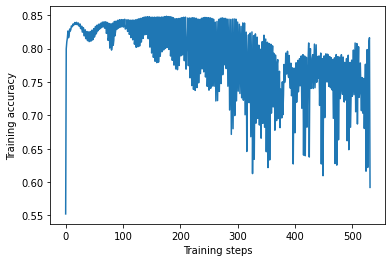

In [ ]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(V_game.train_accuracy_results)

# Fashion MNIST: More environments

In the above experiments, we had 2 environments. We now explore the methods with more environments. We set number of environments to be 10. 

In [ ]:
## Create data for each environment

n_e = 10      # number of environments

p_color_list = [0.2, 0.12, 0.19, 0.22, 0.16, 0.18,0.20, 0.14, 0.12, 0.1]  # list of probabilities of switching the final label to obtain the color index
p_label_list = [0.25]*n_e                                                 # list of probabilities of switching pre-label

D = assemble_data_mnist_fashion()                                         # initialize mnist fashion data object

D.create_training_data(n_e, p_color_list, p_label_list)                  # creates the training environments

p_label_test = 0.25     # probability of switching pre-label in test environment
p_color_test = 0.9      # probability of switching the final label to obtain the color index in test environment

D.create_testing_data(p_color_test, p_label_test, n_e)                   # creates the testing environments
(num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

### Initialize the architecture for F-IRM game 

In the cell below, for each environment we initialize an architecture. We use the MLP architectue that was described in https://arxiv.org/pdf/2002.04692.pdf . 

If you decide to choose a new architecture, please take care to ensure that you keep the input shape as is that is length, width, and height (which we obtained above) and output shape as num_classes.

In [ ]:
model_list = [] # we use same architecture across environments and store it in a list
for e in range(n_e):
    model_list.append(keras.Sequential([
            keras.layers.Flatten(input_shape=(length, width,height)),
            keras.layers.Dense(390, activation = 'elu'),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(390, activation='elu'),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(num_classes)
    ]))

### Select other hyper-parameters for the F-IRM game

In [ ]:

num_epochs       = 25
batch_size       = 256
termination_acc  = 0.75
warm_start       = 10
learning_rate    = 2.5e-4

### Initialize F-IRM model, fit and evaluate

In [ ]:
# initialize F-IRM model (we pass the hyper-parameters that we chose above)
F_game = fixed_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start) 

# fit function runs the training on the data that we created
F_game.fit(D.data_tuple_list)

# evaluate function runs and evaluates train and test accuracy of the final model
F_game.evaluate(D.data_tuple_test) 

# print train and test accuracy
print ("Training accuracy " + str(F_game.train_acc)) 
print ("Testing accuracy " + str(F_game.test_acc))

Epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Training accuracy 0.7358888983726501
Testing accuracy 0.3766666650772095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Selecting termination_acc using training accuracy plot


1. Start by setting a very low termination accuracy value say 0.1 and large number of epochs. 
2. Plot the training accuracy plot to see the range of oscillations; use the minimum value around which oscillation occurs as the threshold 

3. In the above experiment, we found 0.75 to be the value based on the plot.

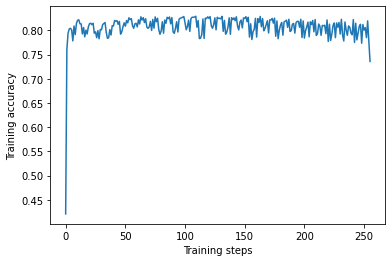

In [ ]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(F_game.train_accuracy_results)

### Initialize the architecture for V-IRM game

In the cell below, for each environment we initialize an architecture. We use the MLP architectue that was described in https://arxiv.org/pdf/2002.04692.pdf . 

If you decide to choose a new architecture, please take care to ensure that you keep the input shape as is that is length, width, and height (which we obtained above) and output shape as num_classes.

In [ ]:
model_list = [] # we use same architecture across environments and store it in a list and the last element of the list 
# corresponds to the architecture for the representation learner
for e in range(n_e+1):
    if(e<=n_e-1): 
        model_list.append( keras.Sequential([
            keras.layers.Flatten(input_shape=(390,1)),
            keras.layers.Dense(390, activation = 'elu'),
            keras.layers.Dropout(0.75),
            keras.layers.Dense(390, activation='elu'),
            keras.layers.Dropout(0.75),
            keras.layers.Dense(num_classes)
        ]))
    if(e==n_e):
        model_list.append(keras.Sequential([
        keras.layers.Flatten(input_shape=(length, width,height)),
        keras.layers.Dense(390, activation = 'elu'),
      ]))

### Select other hyper-parameters for the V-IRM game


In [ ]:
num_epochs       = 25
batch_size       = 64
termination_acc  = 0.75
warm_start       = 25
learning_rate    = 2.5e-4

### Initialize V-IRM model, fit and evaluate

In [ ]:
# initialize V-IRM model (we pass the hyper-parameters that we chose above)
V_game = variable_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start) 

# fit function runs the training on the data that we created
V_game.fit(D.data_tuple_list) 

# evaluate function runs and evaluates train and test accuracy of the final model
V_game.evaluate(D.data_tuple_test) 

# print train and test accuracy
print (V_game.train_acc)
print (V_game.test_acc)

Epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.7410740852355957
0.6525555849075317


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Selecting termination_acc using training accuracy plot


1. Start by setting a very low termination accuracy value say 0.1 and large number of epochs. 
2. Plot the training accuracy plot to see the range of oscillations; use the minimum value around which oscillation occurs as the threshold 

3. In the above experiment, we found 0.75 to be the value based on the plot.

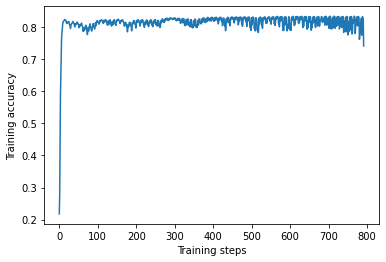

In [ ]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(V_game.train_accuracy_results)

# Fashion MNIST: a simple CNN architecture

In [ ]:
## Create data for each environment

n_e = 2
p_color_list = [0.2, 0.1]
p_label_list = [0.25]*n_e
D = assemble_data_mnist_fashion()  ## assemble_data_mnist() initializes an object whose attributes contain the information about mnist digits data that we create
## this can be replaced with assemble_data_fashion_mnist() for fashion mnist data
D.create_training_data(n_e, p_color_list, p_label_list) ## sets up the training environments
p_label_test = 0.25
p_color_test = 0.9
D.create_testing_data(p_color_test, p_label_test, n_e)  ## sets up the testing environments
(num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape ## obtain attributes of the data
num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

4431872/4422102 [==============================] - 0s 0us/step


### Initialize the architecture for F-IRM game 

In the cell below, for each environment we initialize an architecture. We use a very simple CNN architectue for illustrative purposes. 

If you decide to choose a new architecture, please take care to ensure that you keep the input shape as is that is length, width, and height (which we obtained above) and output shape as num_classes.

In [ ]:

model_list = [] # we use same architecture across environments and store it in a list
for e in range(n_e):
    model_list.append(keras.Sequential([
           keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='elu', input_shape=(length,width,height)),
                keras.layers.Flatten(),
            keras.layers.Dense(390, activation = 'elu'),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(390, activation='elu'),
             keras.layers.Dropout(0.75),
            keras.layers.Dense(num_classes)
    ]))

### Select other hyper-parameters for the F-IRM game

In [ ]:

num_epochs       = 25
batch_size       = 64
termination_acc  = 0.65
warm_start       = 10
learning_rate    = 2.5e-4

### Initialize F-IRM model, fit and evaluate

In [ ]:
# initialize F-IRM model (we pass the hyper-parameters that we chose above)
F_game = fixed_irm_game_model(model_list, learning_rate, num_epochs, batch_size, termination_acc, warm_start) 

# fit function runs the training on the data that we created
F_game.fit(D.data_tuple_list)

# evaluate function runs and evaluates train and test accuracy of the final model
F_game.evaluate(D.data_tuple_test) 

# print train and test accuracy
print ("Training accuracy " + str(F_game.train_acc)) 
print ("Testing accuracy " + str(F_game.test_acc))

### Selecting termination_acc using training accuracy plot

In [ ]:
plt.xlabel("Training steps")
plt.ylabel("Training accuracy")
plt.plot(F_game.train_accuracy_results)

# IRM (Arjovsky et.al.)

In the previous cells, we compared F-IRM and V-IRM approach for 2 environments, multiple environments, and also illustrated the flexibility of using CNN vs MLP. In cells to follow, we compare benchmarks starting with the most important https://arxiv.org/pdf/1907.02893.pdf

### Fashion MNIST: 2 environments

In [ ]:
# Create data for each environment

n_e = 2    # number of environments

p_color_list = [0.2, 0.1]   # list of probabilities of switching the final label to obtain the color index
p_label_list = [0.25]*n_e   # list of probabilities of switching pre-label
D = assemble_data_mnist_fashion()  # initialize mnist fashion data object

D.create_training_data(n_e, p_color_list, p_label_list) # create the training environments
p_label_test = 0.25     # probability of switching pre-label in test environment
p_color_test = 0.9      # probability of switching the final label to obtain the color index in test environment

D.create_testing_data(p_color_test, p_label_test, n_e)  # create the testing environments
(num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

### Initialize the architecture for IRM

The architecture is same as one described here https://github.com/facebookresearch/InvariantRiskMinimization

In [ ]:
model_irm = keras.Sequential([
                keras.layers.Flatten(input_shape=(length,width,height)),
                keras.layers.Dense(390, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(390, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(num_classes)
        ])

### Select other hyper-parameters for the IRM model

In [ ]:
batch_size       = 256
steps_max        = 500
steps_threshold  = 190  ## threshold after which gamma_new is used
learning_rate    = 4.89e-4
gamma_new        = 91257


### IRM model initialize, fit, and evaluate

In [ ]:
irm_model1 = irm_model(model_irm, learning_rate, batch_size, steps_max, steps_threshold, gamma_new)
irm_model1.fit(D.data_tuple_list)
irm_model1.evaluate(D.data_tuple_test)
print ("Training accuracy:" + str(irm_model1.train_acc))
print ("Testing accuracy:" + str(irm_model1.test_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias fo

Training accuracy:0.46618518233299255
Testing accuracy:0.6352221965789795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Fashion MNIST: 10 environments

In [ ]:
## Create data for each environment

n_e = 10      # number of environments

p_color_list = [0.2, 0.12, 0.19, 0.22, 0.16, 0.18,0.20, 0.14, 0.12, 0.1]  # list of probabilities of switching the final label to obtain the color index
p_label_list = [0.25]*n_e                                                 # list of probabilities of switching pre-label

D = assemble_data_mnist_fashion()                                         # initialize mnist fashion data object

D.create_training_data(n_e, p_color_list, p_label_list)                  # creates the training environments

p_label_test = 0.25     # probability of switching pre-label in test environment
p_color_test = 0.9      # probability of switching the final label to obtain the color index in test environment

D.create_testing_data(p_color_test, p_label_test, n_e)                   # creates the testing environments
(num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

### Initialize the architecture for IRM

In [ ]:
model_irm = keras.Sequential([
                keras.layers.Flatten(input_shape=(length,width,height)),
                keras.layers.Dense(390, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(390, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(num_classes)
        ])

### Select other hyper-parameters for the IRM model

In [ ]:
batch_size       = 256
steps_max        = 500
steps_threshold  = 190  ## threshold after which gamma_new is used
learning_rate    = 2.5e-4
gamma_new        = 91257


### Initialize IRM model, fit and evaluate

In [ ]:
irm_model1 = irm_model(model_irm, learning_rate, batch_size, steps_max, steps_threshold, gamma_new)
irm_model1.fit(D.data_tuple_list)
irm_model1.evaluate(D.data_tuple_test)
print ("Training accuracy:" + str(irm_model1.train_acc))
print ("Testing accuracy:" + str(irm_model1.test_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias fo

Training accuracy:0.5077592730522156
Testing accuracy:0.45100000500679016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


#Standard ERM 
### 2 environments

In [ ]:
## Create data for each environment

n_e = 2
p_color_list = [0.2, 0.1]
# p_color_list = [0.2, 0.12, 0.19, 0.22, 0.16, 0.18,0.20, 0.14, 0.12, 0.1]
p_label_list = [0.25]*n_e
D = assemble_data_mnist_fashion()  ## assemble_data_mnist() initializes an object whose attributes contain the information about mnist digits data that we create
## this can be replaced with assemble_data_fashion_mnist() for fashion mnist data
D.create_training_data(n_e, p_color_list, p_label_list) ## sets up the training environments
p_label_test = 0.25
p_color_test = 0.9
D.create_testing_data(p_color_test, p_label_test, n_e)  ## sets up the testing environments
(num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape ## obtain attributes of the data
num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

In [ ]:
model_erm = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28,2)),
        keras.layers.Dense(390, activation = 'elu',kernel_regularizer=keras.regularizers.l2(0.00125)),
        keras.layers.Dropout(0.75),
        keras.layers.Dense(390, activation='elu',kernel_regularizer=keras.regularizers.l2(0.00125)),
        keras.layers.Dropout(0.75),
        #     keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])

In [ ]:
num_epochs = 10
batch_size = 256
learning_rate = 2.5e-3
erm_model1 = standard_erm_model(model_erm, num_epochs, batch_size, learning_rate)
erm_model1.fit(D.data_tuple_list)
erm_model1.evaluate(D.data_tuple_test)
print ("Training accuracy:" + str(erm_model1.train_acc))
print ("Testing accuracy:" + str(erm_model1.test_acc))

Epoch 1/10
211/211 [==============================] - 8s 35ms/step - loss: 1.2018 - accuracy: 0.8080
Epoch 2/10
211/211 [==============================] - 6s 30ms/step - loss: 0.5740 - accuracy: 0.8253
Epoch 3/10
211/211 [==============================] - 7s 32ms/step - loss: 0.4814 - accuracy: 0.8244
Epoch 4/10
211/211 [==============================] - 7s 33ms/step - loss: 0.4652 - accuracy: 0.8256
Epoch 5/10
211/211 [==============================] - 7s 31ms/step - loss: 0.4688 - accuracy: 0.8278
Epoch 6/10
211/211 [==============================] - 6s 30ms/step - loss: 0.4798 - accuracy: 0.8249
Epoch 7/10
211/211 [==============================] - 7s 32ms/step - loss: 0.4883 - accuracy: 0.8243
Epoch 8/10
211/211 [==============================] - 7s 31ms/step - loss: 0.5003 - accuracy: 0.8243
Epoch 9/10
211/211 [==============================] - 7s 33ms/step - loss: 0.5039 - accuracy: 0.8249
Epoch 10/10
211/211 [==============================] - 7s 31ms/step - loss: 0.4990 - accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Training accuracy:0.8404629826545715
Testing accuracy:0.1492222249507904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
